In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# Complex Multinomial Processing Tree (MPT) Model for Aphasia

### Parameters and Model

The model is depicted in the following figure:

<img src="./assets/aphasia.png" width=80% height=80% />

\begin{align}
    \mathrm{NR} &= 1-a, \\
    \mathrm{AN} &= a(1-bc)(1-f)(1-h), \\
    \mathrm{U} &= a[(1-b)f + (1-bc)(1-f)h], \\
    \mathrm{S} &= ab(1-c)f, \\
    \mathrm{F} &= abc[(1-d)f + (1-def)(1-f)g], \\
    \mathrm{N} &= abc(1-f)(1-g), \\
    \mathrm{M} &= abcd(1-e)f, \\
    \mathrm{C} &= abcdef.
\end{align}

The table below lists the four latent parameters and corresponding interpretations:


| Parameter | Description | 
| --- | --- |
| $a$ | Probability of initiating an attempt |
| $t$ | Probability of selecting a target word from a pool of candidates |
| $f$ | Probability of retrieving correct phonemes |
| $c$ | Probability of a phoneme change in the target word |

The table below lists the five types of responses (categories):


| Response (Category) | Description | Example | 
| --- | --- | --- |
| Correct | The response matches the target image. | cat |
| Neologism | The response is not a word, but it has a phonological relation to the target image. | cag |
| Formal | The response is a word with only a phonological relation to the target image. | hat |
| Mixed | The response is a word with both a semantic and phonological relation the target image. | rat |
| Other | All other responses, including omissions, descriptions, non-nouns, etc. | - |

In [2]:
full_mpt_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = 1-a;
  theta[2] = a * (1 - b * c) * (1 - f) * (1 - h);
  theta[3] = a * ((1 - b) * f + (1 - b * c) * (1 - f) * h);
  theta[4] = a * b * (1 - c) * f;
  theta[5] = a * b * c * ((1 - d) * f + (1 - d * e * f) * (1 - f) * g);
  theta[6] = a * b * c * (1 - f) * (1 - g);
  theta[7] = a * b * c * d * (1 - e) * f;
  theta[8] = a * b * c * d * e * f;
}

model {
  a ~ beta(2, 2);
  b ~ beta(2, 2);
  c ~ beta(2, 2);
  d ~ beta(2, 2);
  e ~ beta(2, 2);
  f ~ beta(2, 2);
  g ~ beta(2, 2);
  h ~ beta(2, 2);

  target += dirichlet_lpdf(theta | rep_vector(1, K));
  target += multinomial_lpmf(freqs | theta);
}

generated quantities {
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [1]:
mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> t;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> c;
}

transformed parameters {
  // Model equations go here
  // Prob. Correct
  // Prob. Neologism
  // Prob. Formal
  // Prob. Mixed
  // Prob. Other

  simplex[K] theta;
  theta[1] = a * t * f;
  theta[2] = a * (1 - f) * (1 - c);
  theta[3] = a * (1 - f) * c;
  theta[4] = a * (1 - t) * f;
  theta[5] = 1 - a;
}

model {
  a ~ beta(2, 2);
  t ~ beta(2, 2);
  f ~ beta(2, 2);
  c ~ beta(2, 2);

  target += dirichlet_lpdf(theta | rep_vector(1, K));
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [4]:
a = 0.75
t = 0.8
f = 0.7
c = 0.1

global_rng = np.random.default_rng()

# Fix true probabilities and simulate from model
num_trials = 120
true_probs = {
    'correct': a * t * f,
    'neologism': a * (1 - f) * (1 - c),
    'formal': a * (1 - f) * c,
    'mixed': a * (1 - t) * f,
    'other': 1 - a
}

data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))

In [5]:
mpt_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

mpt_posterior = stan.build(program_code=mpt_model_code, data=mpt_dict, random_seed=2069)

Building...



Building: 26.0s, done.

In [6]:
fit = mpt_posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


### Parameter recovery and predictions

In [7]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.717,0.040,0.640,0.791,0.000,0.000,10149.0,7286.0,1.0
t,0.785,0.054,0.683,0.883,0.001,0.000,10225.0,6651.0,1.0
f,0.593,0.051,0.502,0.695,0.000,0.000,10751.0,7609.0,1.0
c,0.077,0.042,0.009,0.152,0.000,0.000,9563.0,5702.0,1.0
theta[0],0.334,0.041,0.258,0.411,0.000,0.000,9878.0,7353.0,1.0
theta[1],0.269,0.039,0.198,0.344,0.000,0.000,10956.0,7935.0,1.0
theta[2],0.022,0.013,0.003,0.046,0.000,0.000,9306.0,5600.0,1.0
theta[3],0.092,0.025,0.046,0.138,0.000,0.000,10368.0,7305.0,1.0
theta[4],0.283,0.040,0.209,0.360,0.000,0.000,10149.0,7286.0,1.0
preds[0],40.172,7.117,27.000,53.000,0.071,0.050,10087.0,9113.0,1.0


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'preds'}>,
        <Axes: title={'center': 'preds'}>]], dtype=object)

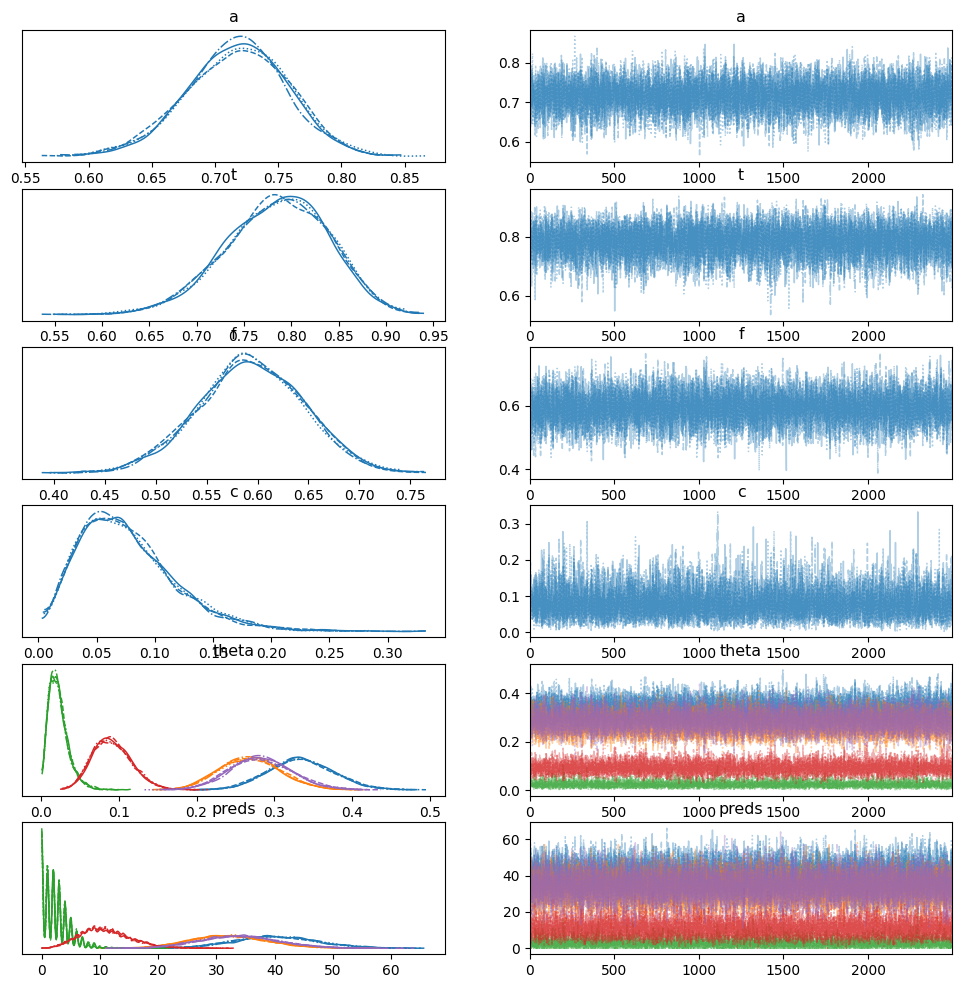

In [8]:
# Convergence
az.plot_trace(fit)